In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [39]:
features_list = [['lat', 'lon'], ['lat', 'lon', 'pop_1km'], ['lat', 'lon', 'pop_1km', 'elevation']]
# features_list = [['lat', 'lon', 'cat_hour']]
target = 'PM2.5'
fold = 2

res_df = {"_".join(features): [] for features in features_list}
with xr.open_dataset("../../data.nc") as ds:
    pass

for features in tqdm(features_list):
    if "cat_hour" in features:
        ds["cat_hour"] = ds.time.dt.hour
    
    for month in tqdm(range(1, 13)):
        month = str(month).zfill(2)
        train_stations = np.load(f"../../fold_{fold}_train.npy", allow_pickle=True)
        test_stations = np.load(f"../../fold_{fold}_test.npy", allow_pickle=True)
        month_ds = ds.sel(time=slice(f"2022-{month}", f"2022-{month}"))
        train_ds = month_ds.sel(station=train_stations)
        test_ds = month_ds.sel(station=test_stations)
        # ds[target] = ds[target].where(ds[f"{target}_missing"] == False)

        #### spatial
        def get_pred(t):
            tmp_train_df = train_ds.sel(time=t).to_dataframe().reset_index()
            tmp_test_df = test_ds.sel(time=t).to_dataframe().reset_index()
            
            if "cat_hour" in features:
                tmp_train_df['cat_hour'] = tmp_train_df['cat_hour'].astype('category')
                tmp_test_df['cat_hour'] = tmp_test_df['cat_hour'].astype('category')
            
            # tmp_train_df = tmp_train_df.dropna(subset=[target])
            x = tmp_train_df[features]
            y = tmp_train_df[target]
            # model = RandomForestRegressor(n_estimators=100, n_jobs=1, random_state=0)
            model = DummyRegressor(strategy="mean")
            model.fit(x, y)
            
            x_test = tmp_test_df[features]
            y_pred = model.predict(x_test)
            tmp_test_df[f'{target}_pred'] = y_pred
            return tmp_test_df

        pred_df_list = Parallel(n_jobs=48)(delayed(get_pred)(t) for t in test_ds.time.values)
        pred_df = pd.concat(pred_df_list)
        ### Normal
    #     train_df = train_ds.to_dataframe().reset_index()
    #     test_df = test_ds.to_dataframe().reset_index()
        
    #     if "cat_hour" in features:
    #         train_df['cat_hour'] = train_df['cat_hour'].astype('category')
    #         test_df['cat_hour'] = test_df['cat_hour'].astype('category')
            
    #     # train_df = train_df.dropna(subset=[target])
    #     x = train_df[features]
    #     y = train_df[target]
    #     model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    #     model.fit(x, y)

    #     x_test = test_df[features]
    #     y_pred = model.predict(x_test)
    #     test_df[f'{target}_pred'] = y_pred        
        
        pred_df = pred_df[pred_df[f"{target}_missing"] == False]

        rmse = np.sqrt(np.mean((pred_df[target] - pred_df[f'{target}_pred'])**2))
        res_df["_".join(features)].append(rmse)
    np.save(f"{'_'.join(features)}_fold_{fold}_res.npy", res_df["_".join(features)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

lat_lon: 43.98099883293141
lat_lon_pop_1km: 43.98099883293141
lat_lon_pop_1km_elevation: 43.98099883293141


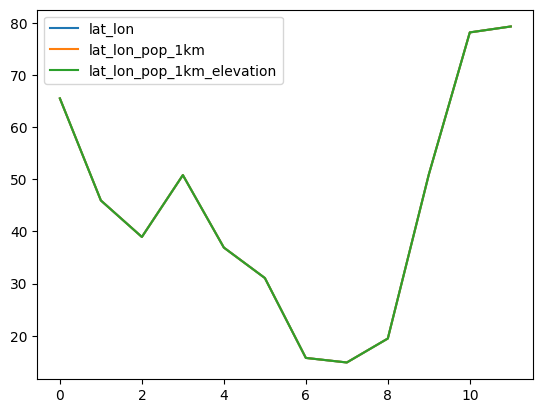

In [41]:
reload_df = {}
fold = 2
for features in ["lat_lon", "lat_lon_pop_1km", "lat_lon_pop_1km_elevation"]:
    reload_df[features] = np.load(f"{features}_fold_{fold}_res.npy", allow_pickle=True)
    print(f"{features}: {np.mean(reload_df[features])}")
    plt.plot(reload_df[features], label=features)
plt.legend()